In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw 
tf.enable_eager_execution()

/home/malzantot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
from syn_dataset import SynDataset
from adl_dataset import ADLDataset
from ecg_dataset import ECGDataset
from data_utils import DataFactory

In [4]:
batch_size = 100


def get_distances(batch_x, batch_y):
    batch_size = batch_x.shape[0]
    d_intra = []
    d_inter = []
    for i in range(batch_size):
        for j in range(batch_size):
            if i == j:
                continue
            if (batch_y[i] == batch_y[j]):
                d, path = fastdtw(batch_x[i], batch_x[j], dist=euclidean)
                d_intra.append(d)
            else:
                continue
    return d_intra, d_inter

In [8]:
real_train, real_test, metadata = DataFactory.create_dataset('ecg')
real_set = real_train.shuffle(batch_size).batch(batch_size)
real_batch_x, real_batch_y = next(iter(real_set))
real_batch_x = real_batch_x.numpy()
real_batch_y = real_batch_y.numpy()
real_d_intra, real_d_inter = get_distances(real_batch_x, real_batch_y)


['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([211, 102]))
['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([72, 33]))


In [24]:
syn_set = SynDataset('samples/ecg_crnn/07_19_16_49', None)
syn_set = syn_set.to_dataset().shuffle(1000).batch(batch_size)
syn_batch_x, syn_batch_y = next(iter(syn_set))
syn_batch_x = syn_batch_x.numpy()
syn_batch_y = syn_batch_y.numpy()
fake_d_intra, fake_d_inter = get_distances(syn_batch_x, syn_batch_y)

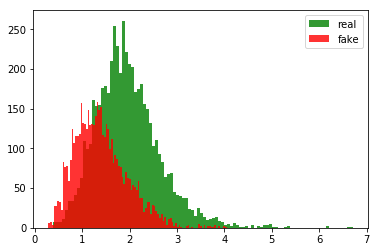

In [27]:
plt.hist(real_d_intra, color='green',bins=100,alpha=0.8,label='real')
plt.hist(fake_d_intra, color='red',bins=100,alpha=0.8,label='fake')
plt.legend()
None